In [1]:
# Import necessary libraries for data handling and model building

import numpy as np  # For linear algebra and array manipulation
import pandas as pd  # For data processing and CSV file handling

import matplotlib.pyplot as plt #data visualization
import seaborn as sns #data visualization

# For preprocessing (encoding)
from sklearn.preprocessing import LabelEncoder  # For encoding and scaling data

# TensorFlow Keras for deep learning model creation
from tensorflow.keras.models import Sequential  # type: ignore # For building the sequential model (stacked layers)
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout  # type: ignore # Layers for the neural network
from tensorflow.keras.callbacks import ModelCheckpoint  # type: ignore # To save the best model during training

# For splitting data into training and testing sets
from sklearn.model_selection import train_test_split

# For model evaluation metrics
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score

# Optimizer to minimize the loss function
from tensorflow.keras.optimizers import Adam # type: ignore

import tensorflow as tf  # For TensorFlow (used in Keras for deep learning)


2024-10-29 19:01:25.644831: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Input data files

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


../data/.DS_Store
../data/X_train.csv
../data/y_train.csv
../data/heart-disease-dataset.csv


In [3]:
# Read Dataset
df=pd.read_csv("../data/heart-disease-dataset.csv")
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [4]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [5]:
# Displays stats about the data
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [ ]:
# Checking for zero values in Cholesterol and RestingBP columns
count_chol_missing = df.loc[df['Cholesterol'] == 0, 'Cholesterol'].count()
count_resting_missing = df.loc[df['RestingBP'] == 0, 'Cholesterol'].count()
print('Missing Values Cholesterol:', count_chol_missing)
print('Missing Values RestingBP:', count_resting_missing)

Missing Values Cholesterol: 172
Missing Values RestingBP: 1


In [ ]:
# Dropping rows with zero values in Cholesterol and RestingBP columns
df = df.drop(df[(df['Cholesterol'] == 0) | (df['RestingBP'] == 0)].index)

# Output Result
print(f"Rows dropped where Cholesterol or RestingBP were 0.")
print(f"Shape of cleaned dataframe: {df.shape}")


Rows dropped where Cholesterol or RestingBP were 0.
Shape of cleaned dataframe: (746, 12)


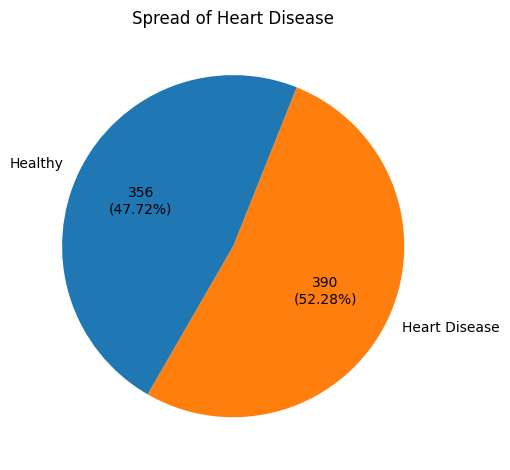

In [8]:
# Display percent and count of dataset with heart disease or healthy for imbalance check
target_values = df['HeartDisease'].value_counts()

# Define a function to display both count and percentage
def func(pct, allvals):
    absolute = int(pct / 100. * sum(allvals))  # Calculate absolute value
    return f'{absolute}\n({pct:.2f}%)'

plt.pie(target_values, 
        labels=['Heart Disease', 'Healthy'],
        autopct=lambda pct: func(pct, target_values),
        startangle=240, 
        colors=['#ff7f0e', '#1f77b4'])

plt.title('Spread of Heart Disease')
plt.tight_layout()
plt.show()


In [39]:
#Creates lists of the columns based on the data type/how data should be visualized
#catagorical variables
cat_vars = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']
#numeric variables
num_vars = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
#label
label = 'HeartDisease'

In [42]:
#Creates functions for plotting variables 

#function for plotting catagoric variables as a bar chart
def display_barchart(data, var, label):
    #calculates the count of patients in each catagory vs heart disease
    grp = data.groupby([var, label])[var].count().unstack().reset_index()

    labels = list(grp.iloc[:, 0].values)
    no_dis = list(grp.iloc[:, 1].values) #no heart disease patients
    yes_dis = list(grp.iloc[:, 2].values) #heart disease patients

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, no_dis, width, label='Healthy')
    rects2 = ax.bar(x + width/2, yes_dis, width, label='Heart Disease')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of Patients')
    ax.set_xlabel(var)
    ax.set_title('Heart Disease by ' + var)
    ax.set_xticks(x) # values
    ax.set_xticklabels(labels) # labels
    ax.legend()

    fig.tight_layout()
    plt.show()

#function for plotting numeric variables as a kde chart
def display_kdechart(data, var):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=data, x=var, hue='HeartDisease')
    plt.title('Heart Disease by ' + var + ' Distribution')
    plt.xlabel(var)  # Optional: label the x-axis
    plt.ylabel('Density')  # Optional: label the y-axis
    plt.show()


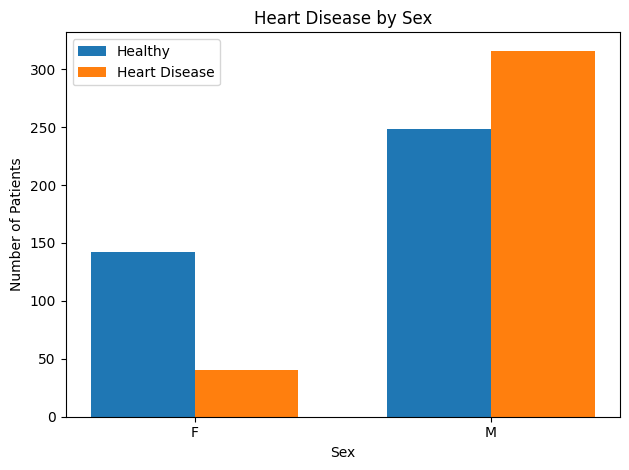

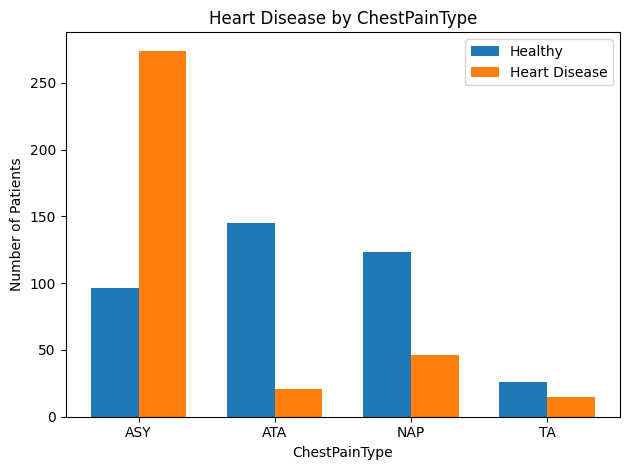

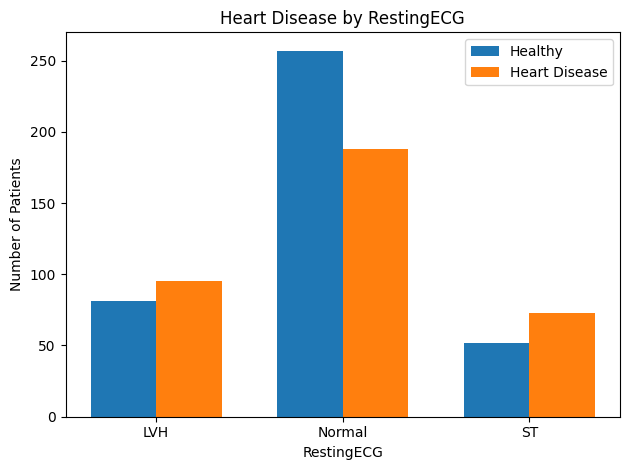

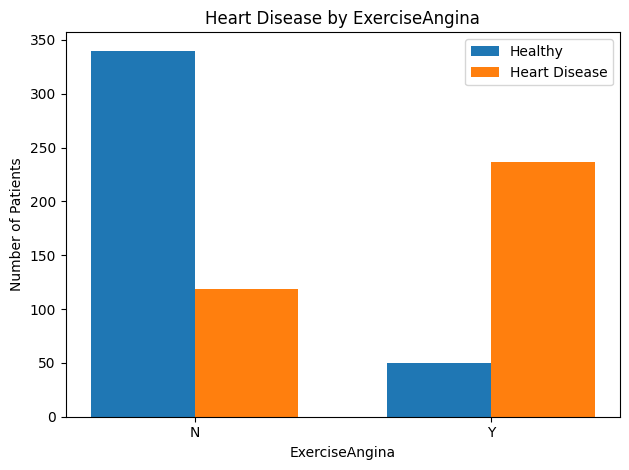

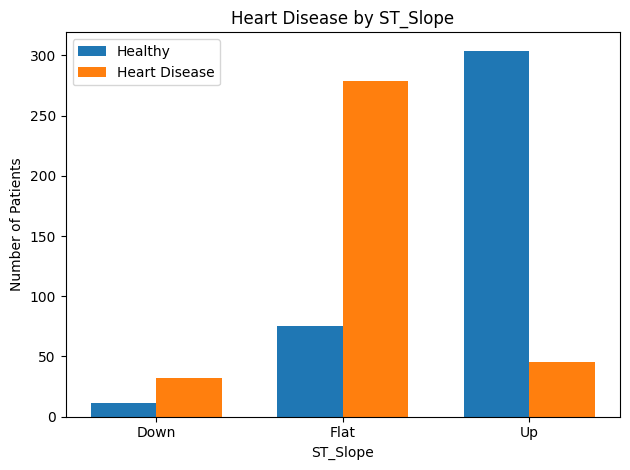

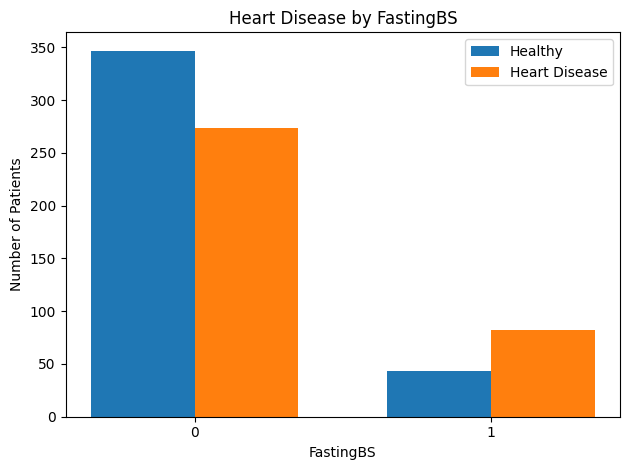

In [43]:
#plots catagoric valriables
for var in cat_vars:
    display_barchart(df, var, label)

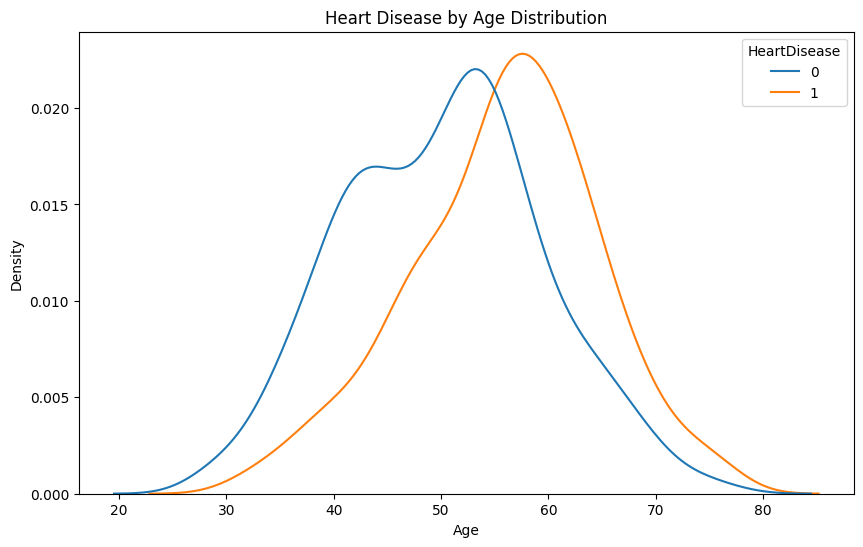

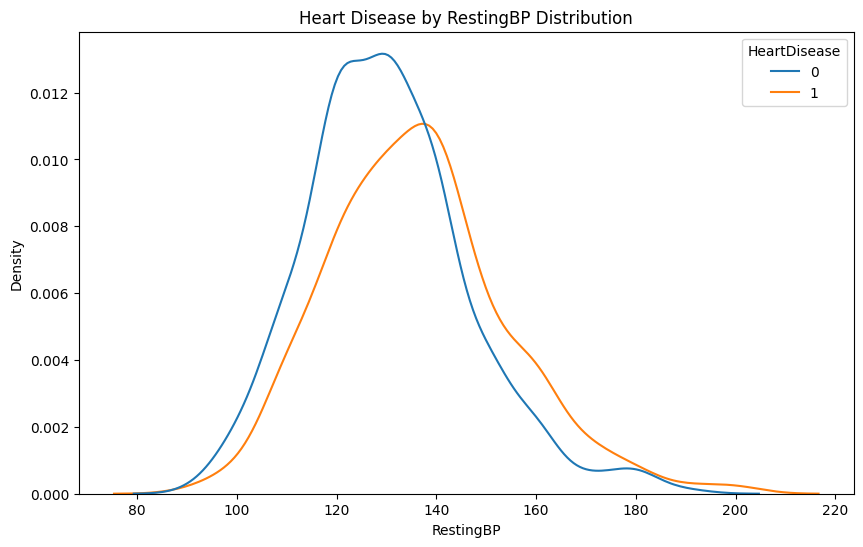

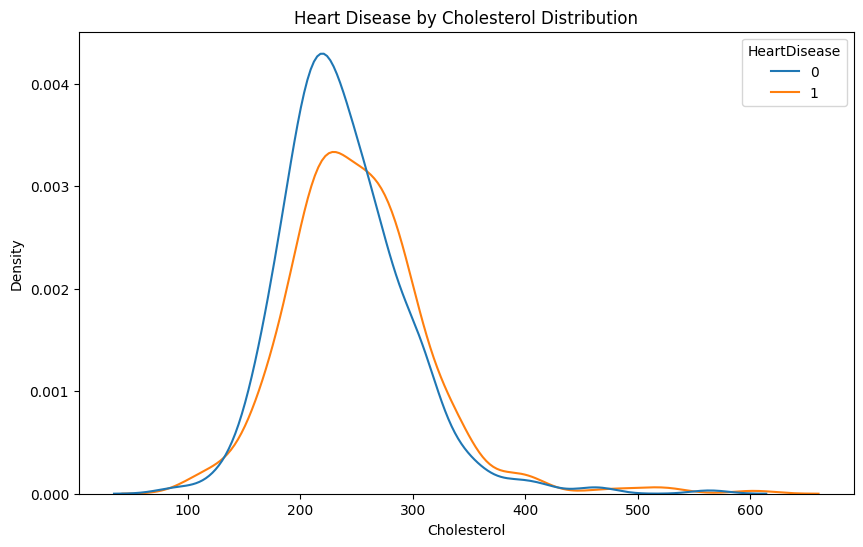

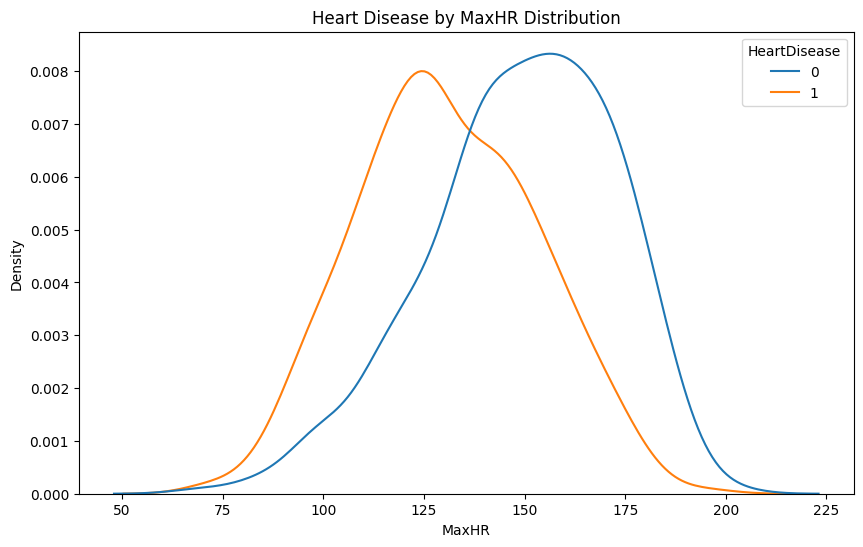

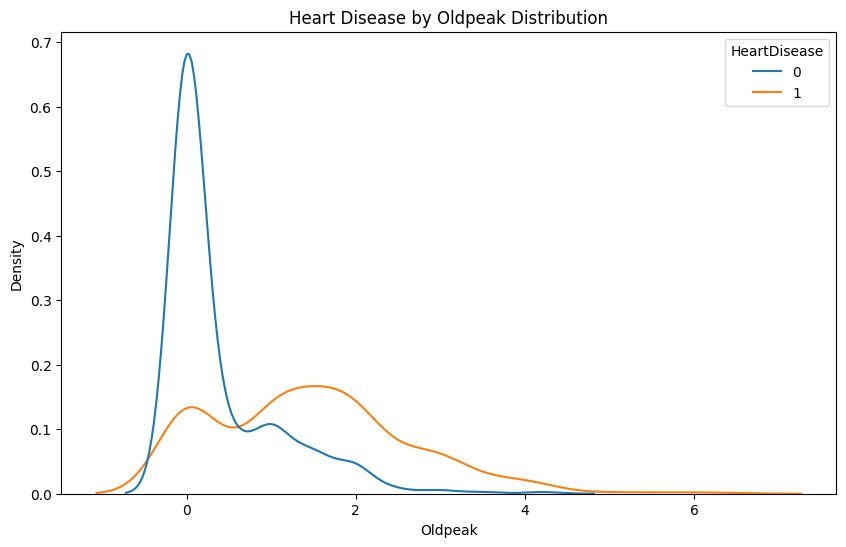

In [44]:
#plots numeric valriables
for var in num_vars:
    display_kdechart(df, var)

In [45]:
# Checking Types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 746 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             746 non-null    int64  
 1   Sex             746 non-null    object 
 2   ChestPainType   746 non-null    object 
 3   RestingBP       746 non-null    int64  
 4   Cholesterol     746 non-null    int64  
 5   FastingBS       746 non-null    int64  
 6   RestingECG      746 non-null    object 
 7   MaxHR           746 non-null    int64  
 8   ExerciseAngina  746 non-null    object 
 9   Oldpeak         746 non-null    float64
 10  ST_Slope        746 non-null    object 
 11  HeartDisease    746 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 75.8+ KB


In [46]:
# Checking for NULLs in the data
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [156]:
# Encode to Numerical and inform what is the outcome
columns_to_encode = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

label_encoders = {}  # Dictionary to save encoder per column

for column in columns_to_encode:
    if column in df.columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le  # Save encoder for that column

# Save result encoding for each column
for column, le in label_encoders.items():
    print(f"\nChanges on column {column}:")
    for idx, class_ in enumerate(le.classes_):
        print(f"  {class_} -> {idx}")



Changes on column Sex:
  F -> 0
  M -> 1

Changes on column ChestPainType:
  ASY -> 0
  ATA -> 1
  NAP -> 2
  TA -> 3

Changes on column RestingECG:
  LVH -> 0
  Normal -> 1
  ST -> 2

Changes on column ExerciseAngina:
  N -> 0
  Y -> 1

Changes on column ST_Slope:
  Down -> 0
  Flat -> 1
  Up -> 2


In [157]:
# Check after encoding
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1,3,110,264,0,1,132,0,1.2,1,1
914,68,1,0,144,193,1,1,141,0,3.4,1,1
915,57,1,0,130,131,0,1,115,1,1.2,1,1
916,57,0,1,130,236,0,0,174,0,0.0,1,1


In [ ]:
# Model Train Neural Network
y = df['HeartDisease']
X = df.drop('HeartDisease', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Save the training data
X_train.to_csv('../data/X_train.csv', index=False)
y_train.to_csv('../data/y_train.csv', index=False)

# Define activation function
activation_func = 'relu'

# Initialize the model
model = Sequential()

# Input layer
model.add(Dense(units=512, input_dim=X_train.shape[1], kernel_initializer='glorot_uniform'))
model.add(Activation(activation_func))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# 1st hidden layer
model.add(Dense(units=256, kernel_initializer='glorot_uniform'))
model.add(Activation(activation_func))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# 2nd hidden layer
model.add(Dense(units=128, kernel_initializer='glorot_uniform'))
model.add(Activation(activation_func))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, kernel_initializer='glorot_uniform'))
model.add(Activation("sigmoid"))

# Compile the model
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

model.fit(X_train, y_train, epochs=200, batch_size=24, validation_split=0.3, callbacks=[checkpoint], verbose=1)

heart_disease_prediction_model = tf.keras.models.load_model('model.keras')

/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.6667 - loss: 0.8728
Epoch 1: val_accuracy improved from -inf to 0.46927, saving model to model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6513 - loss: 0.7892 - val_accuracy: 0.4693 - val_loss: 4.6964
Epoch 2/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5417 - loss: 0.8480
Epoch 2: val_accuracy improved from 0.46927 to 0.47486, saving model to model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6349 - loss: 0.7058 - val_accuracy: 0.4749 - val_loss: 4.7092
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6784 - loss: 0.6548 
Epoch 3: val_accuracy improved from 0.47486 to 0.61453, saving model to model.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6778 - loss: 0.6561 - val_accuracy: 0.6145 - val_loss: 0.6591
Epoch 4/200
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7917 - loss: 0.5327
Epoch 4: val_accuracy did not improve from 0.61453
18/18 ━━━━━

In [171]:
# Load Model for evaluating
heart_disease_prediction_model = tf.keras.models.load_model('model.keras')

In [176]:
# Evaluate Model
probabilities = heart_disease_prediction_model.predict(X_test)

threshold = 0.5

binary_predictions = np.where(probabilities > threshold, 1, 0)

# Display Classification Report
print("Classification Report:")
print(classification_report(y_test, binary_predictions))

# Display the Accuracy
print("Accuracy Score:")
a_score=accuracy_score(y_test,binary_predictions)
print(a_score * 100,"%")

# Display the Precision
print("Precision Score:")
p_score=precision_score(y_test,binary_predictions)
print(p_score * 100,"%")

# Display the Recall
print("Recall Score:")
r_score=recall_score(y_test,binary_predictions)
print(r_score * 100,"%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        78
           1       0.89      0.86      0.87        72

    accuracy                           0.88       150
   macro avg       0.88      0.88      0.88       150
weighted avg       0.88      0.88      0.88       150

Accuracy Score:
88.0 %
Precision Score:
88.57142857142857 %
Recall Score:
86.11111111111111 %
